In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.random as jr
import jax.numpy as jnp

In [7]:
rk = jr.key(0)
jr.normal(rk, (2,))

Array([-0.78476596,  0.85644484], dtype=float32)

In [3]:
import os 
import multiprocessing
import jax
from cohlib.utils import add0
import jax.random as jr

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={multiprocessing.cpu_count()}"
# os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={10}"
jax.config.update('jax_platform_name', 'cpu')
platform = jax.lib.xla_bridge.get_backend().platform.casefold()
print("Platform: ", platform)
print(len(jax.devices()))

Platform:  cpu
28


In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.confs.utils import omega

In [5]:
# L = 10 
# ov2 = -1.0
K = 3
L = 10
seed = 1
mu = -1.0
init = 'empirical'
res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_eigh/inherit-True/m_step-low-rank-eigh/{init}-init_eigvals-fit_eigvecs-fit/newton-10_em-20/res.pkl'
obs_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/obs_sim.pkl'
latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

# latent_load = pickle_open(latent_path)
# obs_load = pickle_open(obs_path)
res_load = pickle_open(res_path)
obs_load = pickle_open(obs_path)
latent_load = pickle_open(latent_path)


In [6]:
import cohlib.confs.utils as conf
from cohlib.general_model import GeneralToyModel
obs = obs_load['obs']
zs_nz = latent_load['zs_nz']
cfg = omega(res_load['cfg'])
lcfg = cfg.latent
mcfg = cfg.model
ocfg = cfg.obs

N = lcfg.num_freqs
freqs = jnp.arange(N)
nz_model = jnp.array([lcfg.target_freq_ind])

init_params = {'rank': mcfg.model_rank, 
            'nz_model': nz_model,
            'scale_init': mcfg.scale_init,
            'K': K,
            'lcfg': lcfg,
            'zs_nz': zs_nz,
            'ocfg': ocfg,
            'obs': obs}

In [7]:
from cohlib.confs.utils import create_lrccn_basic_rank1
lrccn = create_lrccn_basic_rank1(lcfg)

In [8]:
rank = 1
J = 1
eigvals_init = jnp.zeros((J,rank))
eigvecs_init = jnp.zeros((J,K,rank), dtype=complex)
gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
for j in range(J):
    freqind = nz_model[j]
    eigvals_oracle_j, eigvecs_oracle_j = jnp.linalg.eigh(gamma_oracle[freqind,:,:])
    eigvecs_init = eigvecs_init.at[j,:,:].set(eigvecs_oracle_j[:,-rank:][:,::-1])
    eigvals_init = eigvals_init.at[j,:].set(eigvals_oracle_j[-rank:][::-1])

In [9]:
res_load['ccn_init'].eigvals

Array([[1520217.2]], dtype=float32)

In [10]:
def q_func_lowrank_latent(lrccn, sigmas):
    gamma_lrinv = lrccn.get_gamma_pinv()
    gamma_det = jnp.prod(lrccn.eigvals, axis=1)

    a = jnp.trace(gamma_lrinv @ sigmas, axis1=1, axis2=2).sum()
    b = L*(lrccn.rank*jnp.log(jnp.pi) + jnp.log(gamma_det)).sum()

    return -(a+b)


# something is likely wrong here....
def q_func_lowrank_obs(obs, lrccn, rk, M, mu, delta=1e-3):
    # sample zs for monte carlo
    rksplit = jr.split(rk, M)
    obs_lls = jnp.zeros(M)
    L = obs.shape[-1]

    # calculate sample-values for P(O|z^m)
    for m in range(M):
        zs = lrccn.sample(rksplit[m], L)
        zs_0dc = jnp.apply_along_axis(add0, 0, zs)
        xs = jnp.fft.irfft(zs_0dc, axis=0)

        log_lams = xs + mu
        lams = jnp.exp(log_lams)

        obs_ll_calc = obs*(jnp.log(delta) + log_lams) - lams*delta
        obs_lls = obs_lls.at[m].set(obs_ll_calc.sum()) 
    return obs_lls.mean()

In [11]:
r = 0
rk = jr.key(7)
L = obs.shape[-1]

lrccn_init = res_load['track']['ccn'][r]
lrccn_init = res_load['ccn_init']
# calculate sample-values for P(O|z^m)
zs = lrccn_init.sample(rk, L)

zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

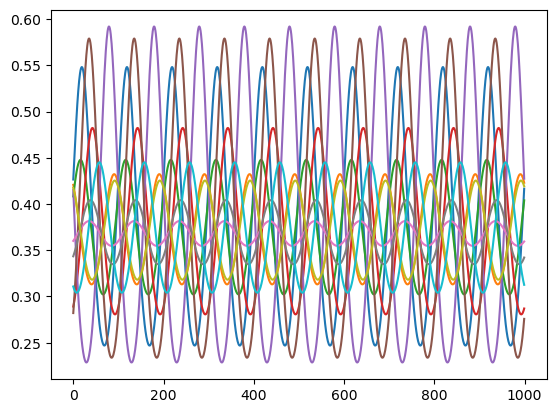

In [12]:
lams = jnp.exp(xs + mu)
k = 0
l = 1
for l in range(L):
    plt.plot(lams[:,k,l])

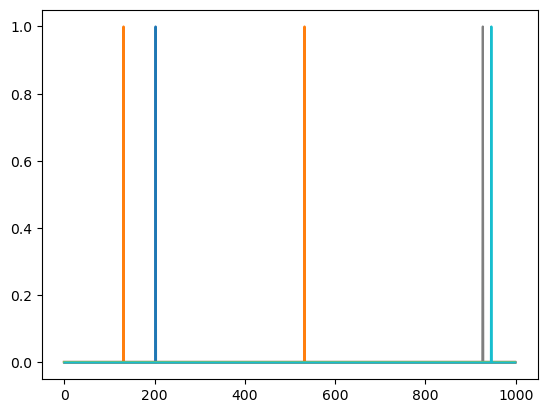

In [13]:
k = 2
for l in range(L):
    plt.plot(obs[:,k,l])

In [14]:
import cohlib.confs.utils as conf
latent_dir = conf.get_latent_dir(cfg.latent)
obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
obs2 = obs_load['obs']

In [15]:
from cohlib.utils import rotate_eigvecs, naive_estimator
naive_est = naive_estimator(obs, nz_model)*1e6
oracle_est = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)

In [16]:
eigvals_naive_raw, eigvecs_naive_raw = jnp.linalg.eigh(naive_est)
eigvals_naive = eigvals_naive_raw[:,::-1]
eigvecs_naive = eigvecs_naive_raw[:,:,::-1]

eigvals_oracle_raw, eigvecs_oracle_raw = jnp.linalg.eigh(oracle_est)
eigvals_oracle = eigvals_oracle_raw[:,::-1]
eigvecs_oracle = eigvecs_oracle_raw[:,:,::-1]


In [17]:
print(eigvecs_naive[0,:,0])
print(rotate_eigvecs(eigvecs_naive)[0,:,0])
print(jnp.angle(rotate_eigvecs(eigvecs_naive)[0,:,0]))

[-0.17228527+0.j          0.5376045 +0.8209299j   0.02410889-0.08241445j]
[ 0.17228527-1.5061657e-08j -0.5376046 -8.2092983e-01j
 -0.02410888+8.2414448e-02j]
[-8.7422777e-08 -2.1505895e+00  1.8553879e+00]


In [18]:
print(eigvecs_oracle[0,:,0])
print(rotate_eigvecs(eigvecs_oracle)[0,:,0])
print(jnp.angle(rotate_eigvecs(eigvecs_oracle)[0,:,0]))

[ 0.5773504 +0.j         -0.2123636 -0.53687507j -0.24837185+0.52119535j]
[ 0.5773504 +0.j         -0.2123636 -0.53687507j -0.24837185+0.52119535j]
[ 0.        -1.947465   2.0155025]


In [19]:
for r in range(5):
    lrccn_r = res_load['track']['ccn'][r]
    eigvecs_em_r = lrccn_r.eigvecs
    angles = jnp.angle(rotate_eigvecs(eigvecs_em_r)[0,:,0])
    angles_nor = jnp.angle((eigvecs_em_r)[0,:,0])
    gamma = lrccn_r.get_gamma()
    print(jnp.round(gamma,-2))

    print('')
    print(jnp.round(rotate_eigvecs(eigvecs_em_r).squeeze(),4))
    print(jnp.round(rotate_eigvecs(eigvecs_em_r).squeeze(),4))
    print(jnp.round(angles,4))
    print(jnp.round(angles_nor,4))
    # gamma = lrccn_r.get_gamma_pinv()
    # print(jnp.round(gamma,9))
    # print(gamma)
    print('')



[[[  45100.     +0.j -140800.+215000.j   -6300. -21600.j]
  [-140800.-215000.j 1463900.     +0.j  -83100. +97400.j]
  [  -6300. +21600.j  -83100. -97400.j   11200.     +0.j]]]

[ 0.1723-0.j         -0.5376-0.82089996j -0.0241+0.0824j    ]
[ 0.1723-0.j         -0.5376-0.82089996j -0.0241+0.0824j    ]
[-0.     -2.1506  1.8554]
[ 3.1416     0.991     -1.2861999]

[[[ 636100.      +0.j  205400. -215700.j -267800.-1144500.j]
  [ 205400. +215700.j  139400.      +0.j  301600. -460300.j]
  [-267800.+1144500.j  301600. +460300.j 2171800.      +0.j]]]

[ 0.4646    -0.j      0.14999999+0.1575j -0.19559999+0.8358j]
[ 0.4646    -0.j      0.14999999+0.1575j -0.19559999+0.8358j]
[-0.      0.8099  1.8007]
[ 3.1416    -2.3316998 -1.3409   ]

[[[ 719700.     +0.j -659400.+950000.j -125000.-285100.j]
  [-659400.-950000.j 1858300.     +0.j -261900.+426200.j]
  [-125000.+285100.j -261900.-426200.j  134700.     +0.j]]]

[ 0.5151+0.j     -0.4719-0.6799j -0.0894+0.2041j]
[ 0.5151+0.j     -0.4719-0.6799j -0.08

In [20]:
from cohlib.utils import add0
import jax.random as jr
M = 25
mcrk = jr.key(7)
num_iters = 10
q_vals = jnp.zeros(num_iters)
q_vals_latent = jnp.zeros(num_iters)
q_vals_obs = jnp.zeros(num_iters)
alphas_emiters = []
Upss_emiters = []
evs_em = []

for r in range(num_iters):
    print(f"Calculating Q-val at update for iteration {r}.")
    # instantiate model at rth iteration
    model = GeneralToyModel()
    lrccn_init = res_load['track']['ccn'][r]
    print("Starting eigvec:")
    print(f"{lrccn_init.eigvecs}")
    obs_params, obs_type = conf.get_obs_params(ocfg)

    model.initialize_latent(lrccn_init)
    model.initialize_observations(obs_params, obs_type)

    fixed_params = conf.get_fixed_params(mcfg.eigvals_flag, mcfg.eigvecs_flag, init_params)

    # run one EM iteration
    fit_params = {'num_em_iters': 1, 
                'num_newton_iters': mcfg.num_newton_iters,
                'm_step_option': mcfg.m_step_option,
                'fixed_params': fixed_params}
    model.fit_em(obs, fit_params)

    # calculate Sigmas 
    alphas = model.alphas
    alphas_emiters.append(alphas)
    Upss = model.Upss
    Upss_emiters.append(Upss)
    alphas_outer = jnp.einsum('nkl,nil->nkil', alphas, alphas.conj())

    evs_em.append(model.lrccn.eigvecs)

    Sigma_ests = (alphas_outer + 2*Upss)

    # calculate q-val at update
    # q_eval_latent = q_func_lowrank_latent(model.lrccn, Sigma_ests).real
    # q_eval_obs = q_func_lowrank_obs(obs, lrccn_init, mcrk, M, mu)
    # q_vals = q_vals.at[r].set(q_eval_latent + q_eval_obs)
    # q_vals_latent = q_vals_latent.at[r].set(q_eval_latent)
    # q_vals_obs = q_vals_obs.at[r].set(q_eval_obs)

Calculating Q-val at update for iteration 0.
Starting eigvec:
[[[-0.17228527+0.j        ]
  [ 0.5376045 +0.8209299j ]
  [ 0.02410889-0.08241445j]]]
EM Iter 1
Running batch 0: trials 1 - 10
eigvec update:
[[[-0.45999998+0.j  ]
  [-0.14999999-0.16j]
  [ 0.19999999-0.84j]]]
eigval update:
[[2947359.2]]
Calculating Q-val at update for iteration 1.
Starting eigvec:
[[[-0.46457705+0.j        ]
  [-0.14998168-0.15752225j]
  [ 0.19561273-0.83582056j]]]
EM Iter 1
Running batch 0: trials 1 - 10
eigvec update:
[[[-0.52-0.j        ]
  [ 0.47+0.68j      ]
  [ 0.09-0.19999999j]]]
eigval update:
[[2712680.5]]
Calculating Q-val at update for iteration 2.
Starting eigvec:
[[[-0.51508045-0.j        ]
  [ 0.4719435 +0.67993975j]
  [ 0.08943572-0.20407024j]]]
EM Iter 1
Running batch 0: trials 1 - 10
eigvec update:
[[[ 0.45999998+0.j  ]
  [ 0.45999998+0.48j]
  [-0.14      +0.57j]]]
eigval update:
[[3152687.]]
Calculating Q-val at update for iteration 3.
Starting eigvec:
[[[ 0.4631217 +0.j        ]
  [ 0.45

In [21]:
lrccn_init = res_load['track']['lrccn'][0]

In [22]:
lrccn_init.get_gamma()

Array([[[  45123.418      +0.j   , -140804.56  +215010.61j ,
           -6314.3843 -21585.254j],
        [-140804.56  -215010.6j  , 1463884.8        +0.j   ,
          -83148.945  +97443.016j],
        [  -6314.3843 +21585.254j,  -83148.945  -97443.016j,
           11209.139      +0.j   ]]], dtype=complex64)

In [23]:
j = 0
l = 0
alphas_emiters[0][j,:,l]

Array([-205.06071 -713.46924j ,   93.372574-123.059044j,
       1278.4845  -167.89767j ], dtype=complex64)

In [24]:
for r in range(10):
    eigvecs = res_load['track']['lrccn'][r].eigvecs
    print(jnp.angle(eigvecs[0,:,-1]*jnp.exp(-1j*jnp.angle(eigvecs[j,0,-1]))))

[-8.7422777e-08 -2.1505895e+00  1.8553879e+00]
[-8.7422777e-08  8.0991501e-01  1.8006952e+00]
[ 8.7422777e-08 -2.1775489e+00  1.9838442e+00]
[0.         0.80670637 1.813481  ]
[ 8.7422777e-08 -2.3071575e+00  1.8621829e+00]
[-8.7422777e-08  4.0221962e-01  1.5139766e+00]
[ 8.7422784e-08 -2.4956837e+00  1.8450111e+00]
[-8.7422777e-08  2.5794756e-01  1.5297827e+00]
[ 8.7422784e-08 -2.6149659e+00  1.8517692e+00]
[-8.7422777e-08  1.5934479e-01  1.5277270e+00]


In [25]:
jnp.angle(eigvecs[j,0,:])

Array([3.1415927], dtype=float32)

In [26]:
jnp.stack(evs_em).squeeze().shape

(10, 3)

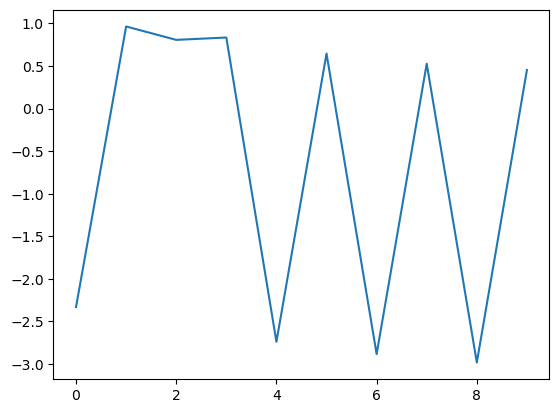

In [28]:
func = jnp.angle
j = 0
dim = 1
eigrank=1
vals = func(jnp.stack(evs_em)[:,j,dim,eigrank])
plt.plot(vals)

In [29]:
vals

Array([-2.3316774 ,  0.96404374,  0.80670637,  0.8344349 , -2.739373  ,
        0.64590895, -2.883645  ,  0.5266266 , -2.9822478 ,  0.4531866 ],      dtype=float32)

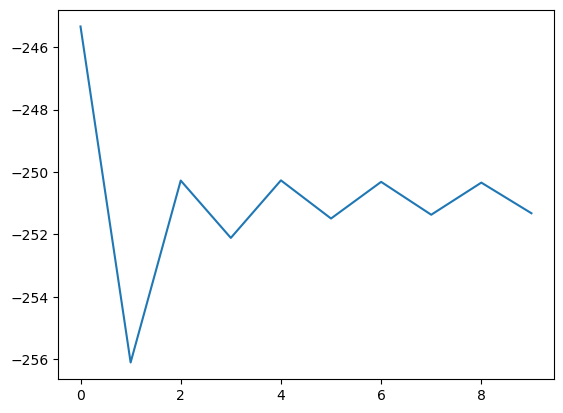

In [20]:
plt.plot(q_vals)

In [21]:
q_vals_obs

Array([-163.15825, -175.6793 , -169.03662, -171.86548, -168.84085,
       -171.29424, -168.82967, -171.20789, -168.80582, -171.18431],      dtype=float32)

In [22]:
q_vals_latent

Array([-82.17969 , -80.426605, -81.23895 , -80.24801 , -81.42871 ,
       -80.19809 , -81.48799 , -80.16332 , -81.53585 , -80.139084],      dtype=float32)

In [ ]:
# this seems suspect.... 

Let's compare true `zs` and `xs` to inferred across em iterations

In [23]:
freqs = latent_load['freqs']
nz = latent_load['nz']
zs_true = jnp.zeros((freqs.size,K,L), dtype=complex)
zs_true = zs_true.at[nz,:,:].set(zs_nz)

zs_true_0dc = jnp.apply_along_axis(add0, 0, zs_true)
xs_true = jnp.fft.irfft(zs_true_0dc, axis=0)

In [24]:
alphas_stack = jnp.stack([alphas_emiters[r] for r in range(num_iters)], axis=-1)
zs_em = jnp.zeros((freqs.size,K,L,num_iters), dtype=complex)
zs_em = zs_em.at[nz,:,:,:].set(alphas_stack)

zs_em_0dc = jnp.apply_along_axis(add0, 0, zs_em)
xs_em = jnp.fft.irfft(zs_em_0dc, axis=0)

In [25]:
xs_em.shape

(1000, 3, 5, 10)

In [26]:
zs_em[nz,:,:,:].shape

(1, 3, 5, 10)

In [27]:
zs_em.shape

(500, 3, 5, 10)

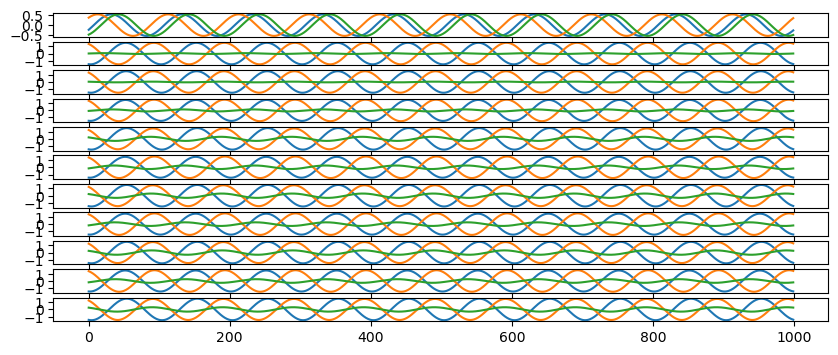

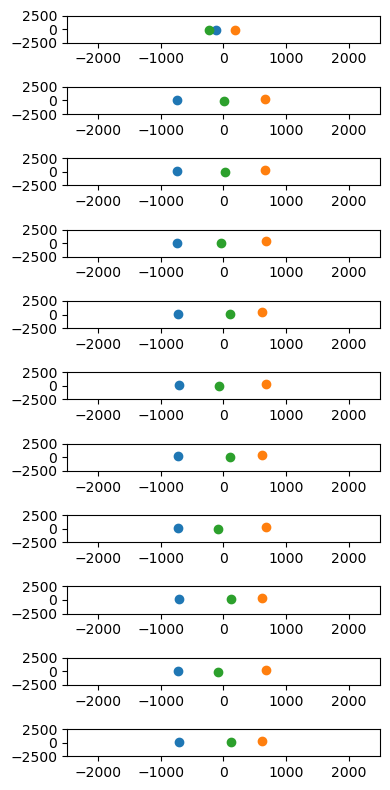

In [37]:
l = 4
fig, ax = plt.subplots(num_iters+1,1, figsize=(10,4))
for k in range(K):
    ax[0].plot(xs_true[:,k,l])
    for r in range(num_iters):
        ax[r+1].plot(xs_em[:,k,l,r])

llim = -2500
ulim = 2500
fig, ax = plt.subplots(num_iters+1,1, figsize=(4,8))
for k in range(K):
    ax[0].scatter(zs_nz[:,k,l].real, zs_nz[:,k,l].imag)
    ax[0].set_xlim([llim,ulim])
    ax[0].set_ylim([llim,ulim])
    for r in range(num_iters):
        ax[r+1].scatter(zs_em[nz,k,l,r].real, zs_em[nz,k,l,r].imag)
        ax[r+1].set_xlim([llim,ulim])
        ax[r+1].set_ylim([llim,ulim])
        # ax[r+1].scatter(xs_em[:,k,l,r])
plt.tight_layout()

In [42]:
obs.sum()

Array(21, dtype=int32)

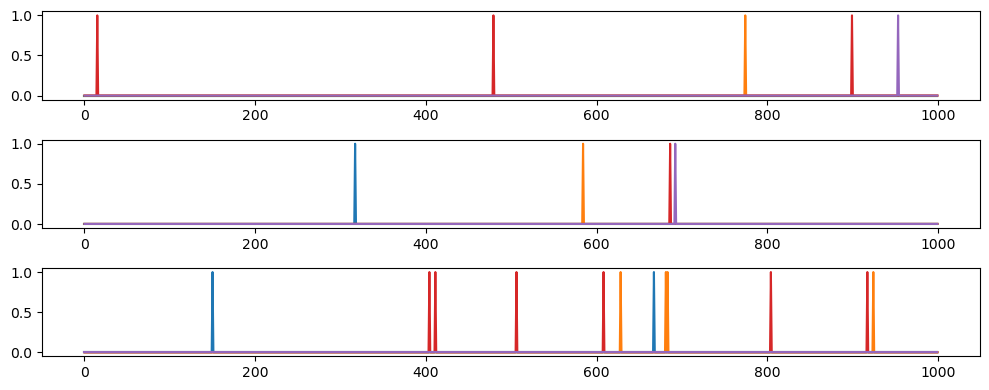

In [41]:
fig, ax = plt.subplots(3,1,figsize=(10,4))
for l in range(L):
    # for k in range(K):
        # ax[k].plot(obs[:,k,l])
    ax[0].plot(obs[:,0,l])
    ax[1].plot(obs[:,1,l])
    ax[2].plot(obs[:,2,l])

plt.tight_layout()
    

In [47]:
Upss_stack = jnp.stack(Upss_emiters,axis=-1)

/projectnb/stephenlab/jtauber/.conda/envs/sgc_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


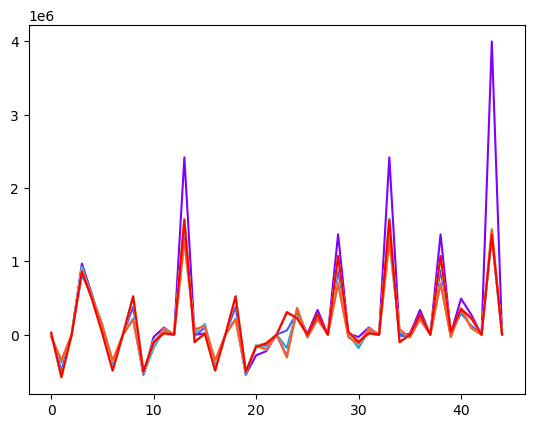

In [58]:
# Upss_stack.shape

color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
for r in range(num_iters):
    alphas_outer = jnp.einsum('jil,jkl->jikl', alphas_emiters[r], alphas_emiters[r])
    alphas_outer_flat = alphas_outer.flatten()
    # print(alphas_outer.shape)
    plt.plot(alphas_outer_flat, color=color[r])

/projectnb/stephenlab/jtauber/.conda/envs/sgc_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


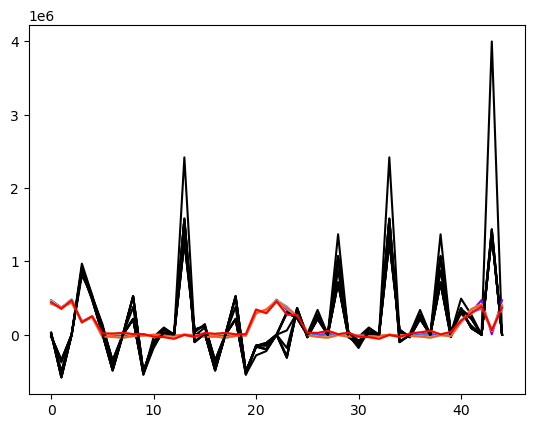

In [59]:
# Upss_stack.shape

color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
for r in range(num_iters):
    alphas_outer = jnp.einsum('jil,jkl->jikl', alphas_emiters[r], alphas_emiters[r])
    alphas_outer_flat = alphas_outer.flatten()
    # print(alphas_outer.shape)
    plt.plot(alphas_outer_flat, color='k')

    Upss_flat = Upss_emiters[r].flatten()
    plt.plot(Upss_flat, color=color[r])

In [53]:
alphas_emiters[0].shape

(1, 3, 5)

In [19]:
gamma_lrinv = lrccn.get_gamma_pinv()
gamma_lrinv.shape

(1, 3, 3)

In [25]:
jnp.trace(gamma_lrinv @ Sigma_ests, axis1=1, axis2=2).sum()

Array(53.076782-0.09939098j, dtype=complex64)

In [26]:
jnp.trace(gamma_lrinv @ Sigma_ests, axis1=1, axis2=2)

Array([53.75+0.0324707j], dtype=complex64)

In [31]:
(gamma_lrinv @ Sigma_ests).sum(-1)

Array([[[ 2022.751 -1263.9888j,  2022.751 -1263.9888j,
          2022.751 -1263.9888j],
        [ -419.8695 -295.1026j,  -419.8695 -295.1026j,
          -419.8695 -295.1026j],
        [-1549.8047+1558.9921j, -1549.8047+1558.9921j,
         -1549.8047+1558.9921j]]], dtype=complex64)

In [53]:
arr = jnp.array([[1,2,3],[2,3,4]])
test = jnp.prod(arr, axis=1)
test.shape

(2,)

In [51]:
jnp.prod(lrccn.eigvals, axis=1)

Array([3.], dtype=float32)

In [57]:
sigmas = Sigma_ests
gamma_lrinv = lrccn.get_gamma_pinv()
gamma_det = jnp.prod(lrccn.eigvals, axis=1)

a = jnp.trace(gamma_lrinv @ sigmas, axis1=1, axis2=2)
b = L*(lrccn.rank*jnp.log(jnp.pi) + jnp.log(gamma_det))

Array([112.16711], dtype=float32)

In [92]:
lrccn = res_load['track']['lrccn'][3]
rk = jr.key(7)

data = obs
delta = 1e-3
M = 5
# zs = lrccn.sample_nz(rk, M)
rksplit = jr.split(rk, M)
obs_lls = jnp.zeros(M)
for m in range(M):
    zs = lrccn.sample(rksplit[m], L)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    log_lams = xs + mu
    lams = jnp.exp(log_lams)

    obs_ll_calc = data*(jnp.log(delta) + log_lams) - lams*delta
    obs_lls = obs_lls.at[m].set(obs_ll_calc.sum()) 

In [94]:
obs_lls.mean()

Array(-3211.3528, dtype=float32)

Array(-3069.7825, dtype=float32)

In [84]:
lrccn.eigvecs

Array([[[ 0.68994766+6.031714e-08j],
        [-0.24277136-3.568223e-01j],
        [-0.14391638+5.630276e-01j]]], dtype=complex64)

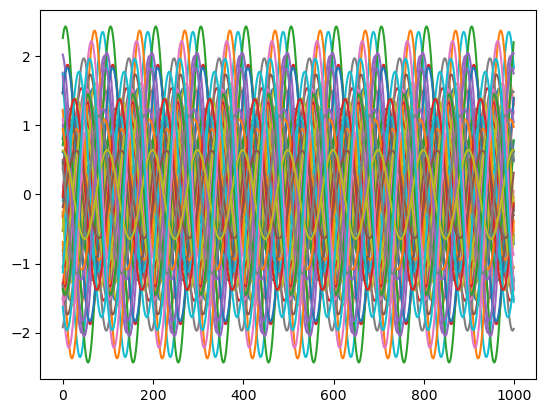

In [87]:
for l in range(L):
    plt.plot(xs[:,1,l])

In [71]:
log_lams = xs + mu
lams = jnp.exp(log_lams)

In [ ]:
def Q_func(Gamma_r, Gamma_r_inv, Sigmas_r):
    L = Sigmas_r.shape[0]
    K = Gamma_r_inv.shape[1]
    sum_A = L*(K*np.log(np.pi) + np.log(np.abs(np.linalg.det(Gamma_r)))).sum()
    sum_B = np.trace(Gamma_r_inv @ Sigmas_r, axis1=2, axis2=3).sum()
    Q = -(sum_A + sum_B)

    return sum_A, sum_B, Q.real